In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Set up**

## Automatically generating object masks with SAM

In [3]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

In [4]:
using_colab = True

In [5]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-757i6s_f
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-757i6s_f
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=2c4f5bd239e8bf380df5c664e82f34a6b14e6ac41cb0c46e530de9105efed5a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-2gzgo32n/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-02-05 10:14:15--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [7]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# **Imports**

In [8]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import os
from glob import glob
import shutil


# **Example**

## RGB Example image

In [ ]:
image = cv2.imread('/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231103/2_n_13_20231103.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

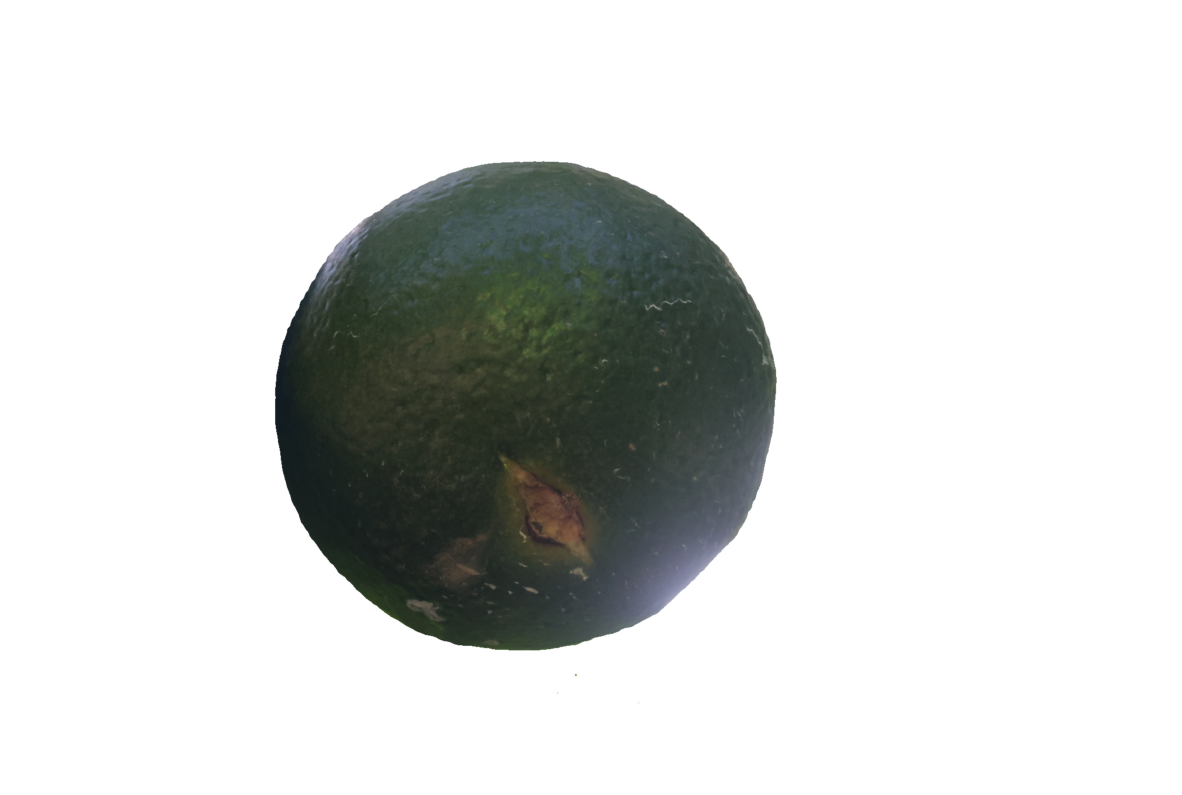

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


To generate masks, just run `generate` on an image.

In [ ]:
# Resize image to reduce memory usage
scale_factor = 0.25  # Adjust if needed for performance
new_width = int(image.shape[1] * scale_factor)
new_height = int(image.shape[0] * scale_factor)
image_resized = cv2.resize(image, (new_width, new_height))

In [ ]:

masks = mask_generator.generate(image_resized)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

6
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
# Sort masks by area in descending order
masks_sorted = sorted(masks, key=lambda x: x['area'], reverse=True)

# Delete the two largest segments (mandarin itself and background)
filtered_masks = masks_sorted[2:] if len(masks_sorted) > 2 else []


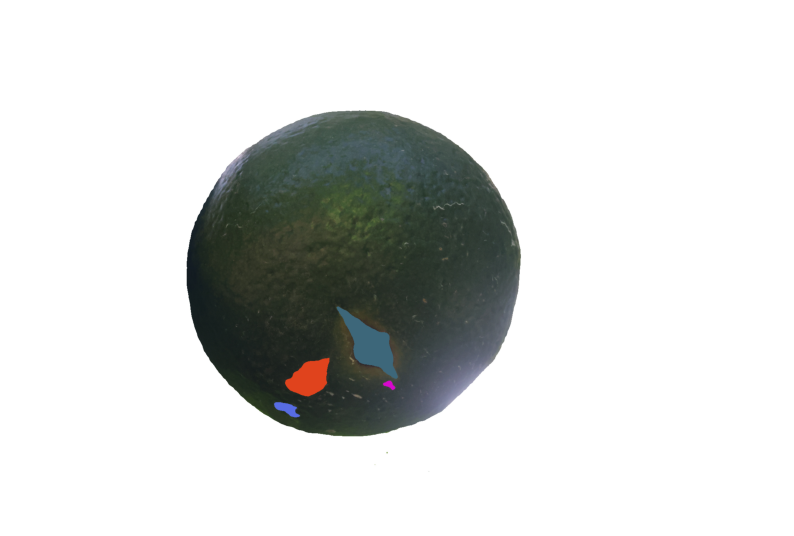

In [ ]:
# Display filtered masks overlaid on the original image
plt.figure(figsize=(10, 10))
plt.imshow(image_resized)

def show_filtered_masks(image, masks):
    if not masks:
        print("No inner segments found")
        return
    overlay = image.copy()
    for mask in masks:
        color = np.random.rand(3,)  # Random color for each mask
        segmentation = mask['segmentation']
        overlay[segmentation] = (color * 255).astype(np.uint8)
    plt.imshow(overlay)

show_filtered_masks(image_resized, filtered_masks)
plt.axis('off')
plt.show()

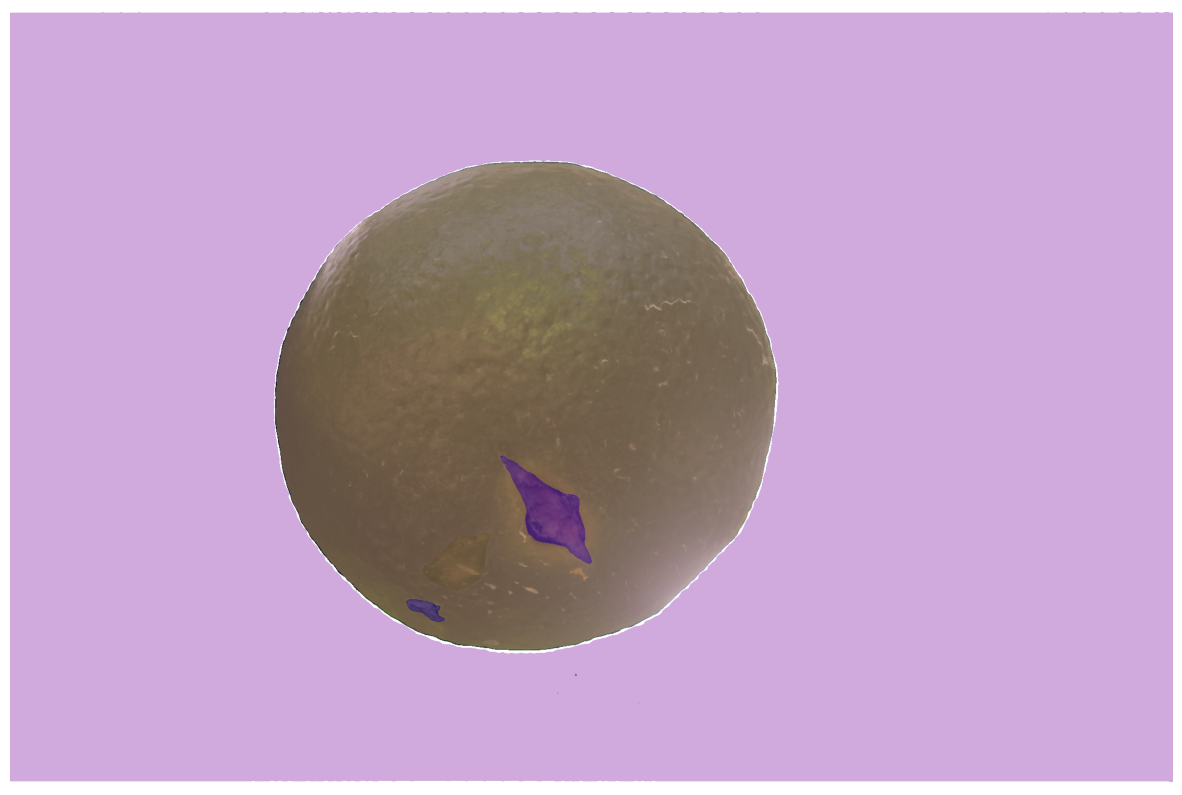

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(image_resized)
show_anns(masks)
plt.axis('off')
plt.show()

Show all the masks overlayed on the image.

In [ ]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import os

# def calculate_circularity(mask):
#     # Convert boolean mask to uint8 type
#     mask_uint8 = (mask.astype(np.uint8)) * 255  # Convert to 0 and 255

#     # Finding contours of the mask
#     contours, _ = cv2.findContours(mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#     # Check if any contours were found
#     if len(contours) == 0:
#         return 0

#     # Assuming the largest contour corresponds to the mask of interest
#     largest_contour = max(contours, key=cv2.contourArea)
#     area = cv2.contourArea(largest_contour)
#     perimeter = cv2.arcLength(largest_contour, True)

#     # Avoid division by zero
#     if perimeter == 0:
#         return 0

#     # Calculate circularity
#     circularity = (4 * np.pi * area) / (perimeter ** 2)
#     return circularity

# def find_most_circular_mask(masks, image_area):
#     max_circularity = 0
#     best_mask = None
#     min_area_threshold = image_area * 0.02  # 2% of the image area

#     for mask in masks:
#         # Assume mask['segmentation'] is a binary mask of the segmented area
#         area = np.sum(mask['segmentation'])

#         if area >= min_area_threshold:
#             circularity = calculate_circularity(mask['segmentation'])
#             if circularity > max_circularity:
#                 max_circularity = circularity
#                 best_mask = mask

#     return best_mask

# # Assuming 'masks' is a list of dictionaries with each containing a 'segmentation' key for the mask
# image_size = image.shape[0] * image.shape[1]  # Calculate total image area
# most_circular_mask = find_most_circular_mask(masks, image_size)

# # Show and save the most circular mask
# if most_circular_mask is not None:
#     plt.figure(figsize=(10, 10))
#     plt.imshow(most_circular_mask['segmentation'], cmap='gray')
#     plt.title("Most Circular Mask")
#     plt.axis('off')

#     # Define the path to save the mask image
#     save_path = '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator'
#     image_name = "original_image_name_masked.png"  # Replace 'original_image_name' with actual image name without extension
#     full_path = os.path.join(save_path, image_name)

#     # Save the figure
#     plt.savefig(full_path, bbox_inches='tight', pad_inches=0)
#     plt.close()
#     print(f"Mask saved to {full_path}")
# else:
#     print("No suitable mask found.")


Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/original_image_name_masked.png


# **Object Segmentation**

## Automatic mask all RGB images

In [ ]:
# Set up the SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)


/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [ ]:
# Set up the SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to calculate circularity
def calculate_circularity(mask):
    mask_uint8 = (mask.astype(np.uint8)) * 255  # Convert to 0 and 255
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0

    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)

    if perimeter == 0:
        return 0

    circularity = (4 * np.pi * area) / (perimeter ** 2)
    return circularity

# Function to find the most circular mask
def find_most_circular_mask(masks, image_area):
    max_circularity = 0
    best_mask = None
    min_area_threshold = image_area * 0.02  # 2% of the image area

    for mask in masks:
        area = np.sum(mask['segmentation'])
        if area >= min_area_threshold:
            circularity = calculate_circularity(mask['segmentation'])
            if circularity > max_circularity:
                max_circularity = circularity
                best_mask = mask

    return best_mask

# List of directories to process
image_directories = [
    '/content/drive/Othercomputers/My PC/Thesis/raw_data/20241129/raw data/RGB/new_name'
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20241102/raw data/RGB/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20240927/raw data/RGB/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/RGB/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231216/prediction/raw data/RGB/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231103/prediction/raw data/RGB/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230929/prediction/raw data/RGB/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230825/Prediction/RGB/new_name'
]

# Base folder to save the masks
base_save_path = '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion'

# Process all images in the directories
for directory in image_directories:
    # Extract the date directly from the directory name
    # Assuming date is the first component with format YYYYMMDD after the base directory
    path_parts = directory.split('/')
    date_str = next((part for part in path_parts if part.isdigit() and len(part) == 8), "unknown_date")

    # Create a date-specific save path
    date_save_path = os.path.join(base_save_path, date_str)
    os.makedirs(date_save_path, exist_ok=True)

    # Process each image in the directory
    image_paths = glob(os.path.join(directory, '*.JPG'))  # Assuming images are in .JPG format

    for image_path in image_paths:
        # Create the save path for the mask
        image_name = os.path.basename(image_path).replace('.JPG', '_masked.png')
        full_save_path = os.path.join(date_save_path, image_name)

        # Check if the masked image already exists
        if os.path.exists(full_save_path):
            print(f"Masked image already exists for {image_name}. Skipping...")
            continue  # Skip if the masked image already exists

        # Load and resize the image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        scale_factor = 0.25
        new_width = int(image_rgb.shape[1] * scale_factor)
        new_height = int(image_rgb.shape[0] * scale_factor)
        image_resized = cv2.resize(image_rgb, (new_width, new_height))

        # Generate masks using SAM
        masks = mask_generator.generate(image_resized)
        image_size = image_resized.shape[0] * image_resized.shape[1]

        # Find the most circular mask
        most_circular_mask = find_most_circular_mask(masks, image_size)

        if most_circular_mask is not None:
            # Convert mask to uint8
            mask_uint8 = (most_circular_mask['segmentation'].astype(np.uint8)) * 255

            # Save the mask
            cv2.imwrite(full_save_path, mask_uint8)
            print(f"Mask saved to {full_save_path}")
        else:
            print(f"No suitable mask found for {image_path}")


Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/1_e_4_20241102_RGB_masked.png
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/1_e_5_20241102_RGB_masked.png
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/1_e_7_20241102_RGB_masked.png
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/2_e_1_20241102_RGB_masked.png
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/2_e_2_20241102_RGB_masked.png
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/2_e_3_20241102_RGB_masked.png
Mask saved to /content/drive/Other

Increase masked images to original size and save outcome

In [ ]:
# Input and output directories
input_dir = '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129'
target_size = (8192, 5464)  # Width, Height

# Process all subdirectories and images within `RGB`
for root, dirs, files in os.walk(input_dir):
    for file_name in files:
        if file_name.endswith('.png'):
            image_path = os.path.join(root, file_name)

            # Load the image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Check if the image is already the target size
            if image.shape[1] == target_size[0] and image.shape[0] == target_size[1]:
                print(f"Image {file_name} is already at target size. Skipping...")
                continue

            # Resize and overwrite the existing image
            resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_NEAREST)
            cv2.imwrite(image_path, resized_image)
            print(f"Resized and saved: {image_path}")




Resized and saved: /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/1_e_4_20241102_RGB_masked.png
Resized and saved: /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/1_e_5_20241102_RGB_masked.png
Resized and saved: /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/1_e_7_20241102_RGB_masked.png
Resized and saved: /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/2_e_1_20241102_RGB_masked.png
Resized and saved: /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/2_e_2_20241102_RGB_masked.png
Resized and saved: /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/RGB_small_resulotion/20241129/2_e_3_20241102_RGB_masked.png
Resi

## Automatic mask all tiff images

this code mask the image and saves it in the original resolution

In [9]:
# Set up the SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)

# Function to calculate circularity
def calculate_circularity(mask):
    mask_uint8 = (mask.astype(np.uint8)) * 255  # Convert to 0 and 255
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0

    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)
    perimeter = cv2.arcLength(largest_contour, True)

    if perimeter == 0:
        return 0

    circularity = (4 * np.pi * area) / (perimeter ** 2)
    return circularity

# Function to find the most circular mask
def find_most_circular_mask(masks, image_area):
    max_circularity = 0
    best_mask = None
    min_area_threshold = image_area * 0.02  # 2% of the image area

    for mask in masks:
        area = np.sum(mask['segmentation'])
        if area >= min_area_threshold:
            circularity = calculate_circularity(mask['segmentation'])
            if circularity > max_circularity:
                max_circularity = circularity
                best_mask = mask

    return best_mask

# List of directories to process
image_directories = [
    '/content/drive/Othercomputers/My PC/Thesis/raw_data/20241129/raw data/tiff/new_name'
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20241102/raw data/tiff/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20240927/raw data/tiff/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/tiff/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231216/prediction/raw data/tiff/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231103/prediction/raw data/tiff/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230929/prediction/raw data/tiff/new_name',
    # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230825/Prediction/tiff/new_name'
]


# Base folder to save the masks
base_save_path = '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/Thermal'


# Process all images in the directories
for directory in image_directories:
    # Extract the date directly from the directory name
    # Assuming date is the first component with format YYYYMMDD after the base directory
    path_parts = directory.split('/')
    date_str = next((part for part in path_parts if part.isdigit() and len(part) == 8), "unknown_date")

    # Create a date-specific save path
    save_path = os.path.join(base_save_path, date_str)
    os.makedirs(save_path, exist_ok=True)

    image_paths = glob(os.path.join(directory, '*.tiff'))  # Assuming images are in .jpg format

    for image_path in image_paths:
        # Create the save path for the mask
        image_name = os.path.basename(image_path).replace('.tiff', '.tiff')  # Saving as TIFF
        full_save_path = os.path.join(save_path, image_name)

        # Check if the masked image already exists
        if os.path.exists(full_save_path):
            print(f"Masked image already exists for {image_name}. Skipping...")
            continue  # Skip if the masked image already exists

        # Load the original image without resizing
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        original_height, original_width = image.shape[:2]  # Get original dimensions

        # Check if the image is grayscale and convert to 3 channels if needed
        if len(image.shape) == 2:  # Grayscale image
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to 3-channel RGB

        # Resize the image for processing (using the scale factor)
        scale_factor = 0.25
        new_width = int(original_width * scale_factor)
        new_height = int(original_height * scale_factor)
        image_resized = cv2.resize(image, (new_width, new_height))

        # Generate masks using SAM
        masks = mask_generator.generate(image_resized)
        image_size = image_resized.shape[0] * image_resized.shape[1]

        # Find the most circular mask
        most_circular_mask = find_most_circular_mask(masks, image_size)

        if most_circular_mask is not None:
            # Convert mask to uint8
            mask_uint8 = (most_circular_mask['segmentation'].astype(np.uint8)) * 255

            # Resize the mask back to the original image dimensions
            mask_original_size = cv2.resize(mask_uint8, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

            # Save the mask as a TIFF file
            cv2.imwrite(full_save_path, mask_original_size)
            print(f"Mask saved to {full_save_path}")
        else:
            print(f"No suitable mask found for {image_path}")


/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/Thermal/20241129/1_e_4_20241129_Thermal.tiff
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/Thermal/20241129/1_e_5_20241129_Thermal.tiff
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/Thermal/20241129/1_e_7_20241129_Thermal.tiff
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/Thermal/20241129/2_e_1_20241129_Thermal.tiff
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/Thermal/20241129/2_e_2_20241129_Thermal.tiff
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/Thermal/20241129/2_e_3_20241129_Thermal.tiff
Mask saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/SAM_automate_mask_ganarator/Thermal/20241129/2_e_4_

# **Crack Segmentation**

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

# Load the SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Initialize the mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


<ipython-input-9-80643f296f6c>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/1_s_1_20231216.JPG


<ipython-input-9-80643f296f6c>:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):


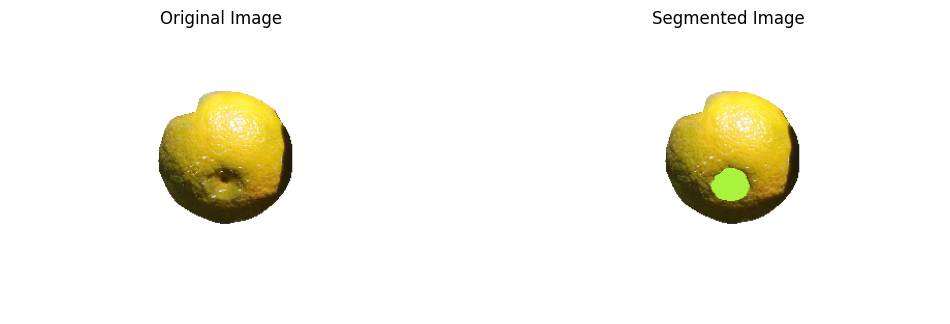

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/24_n_1_20231216.JPG


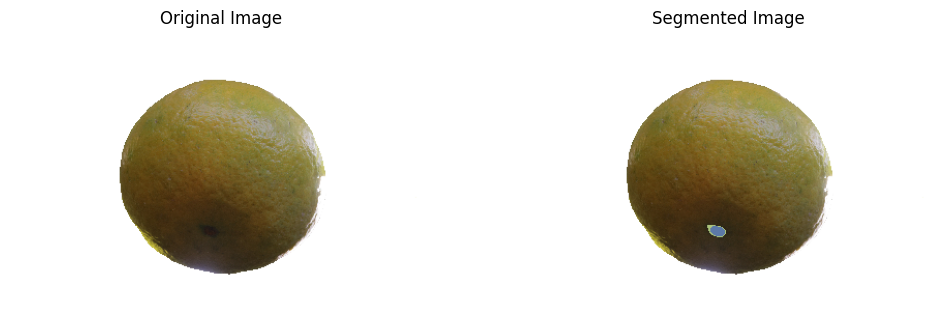

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/2_n_14_20231216.JPG


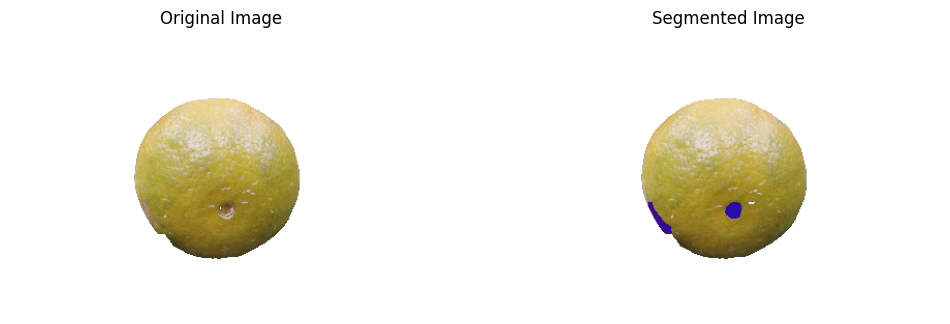

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/10_s_4_20231216.JPG


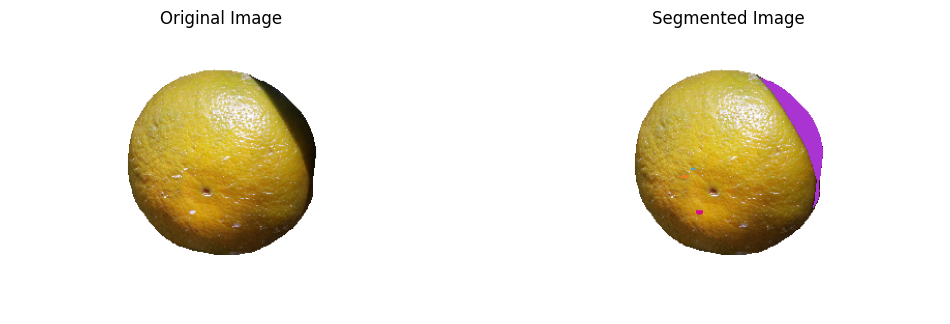

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/25_n_5_20231216.JPG


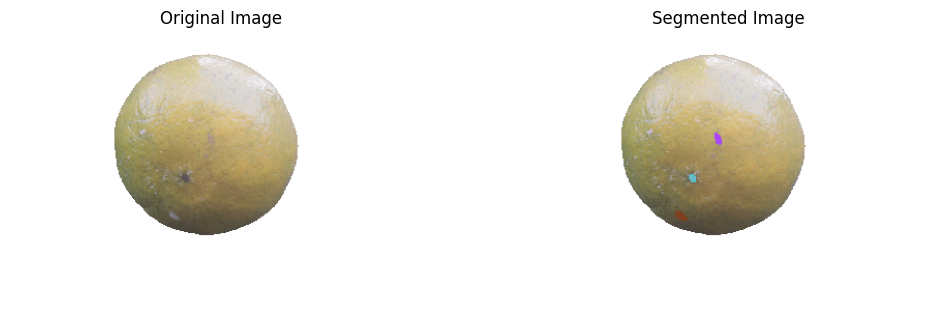

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/14_n_3_20231216.JPG


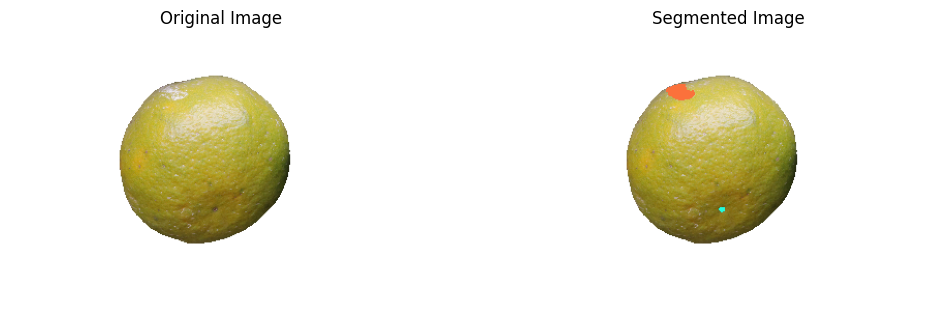

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/1_s_5_20231216.JPG


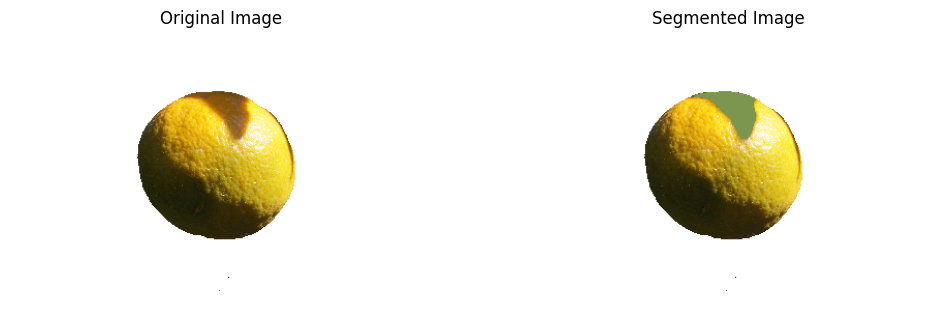

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/15_n_1_20231216.JPG


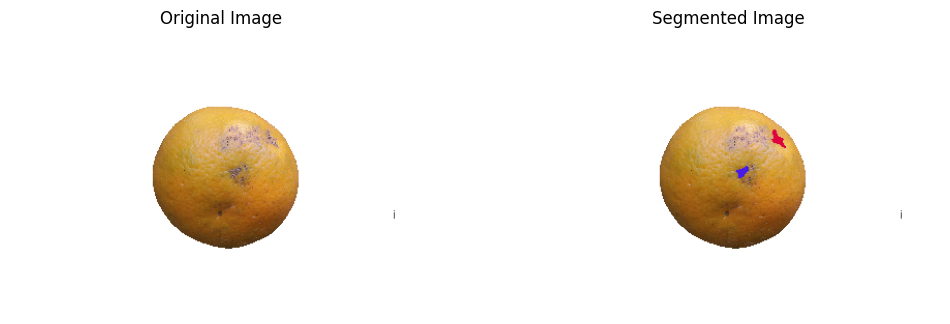

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/4_n_4_20231216.JPG


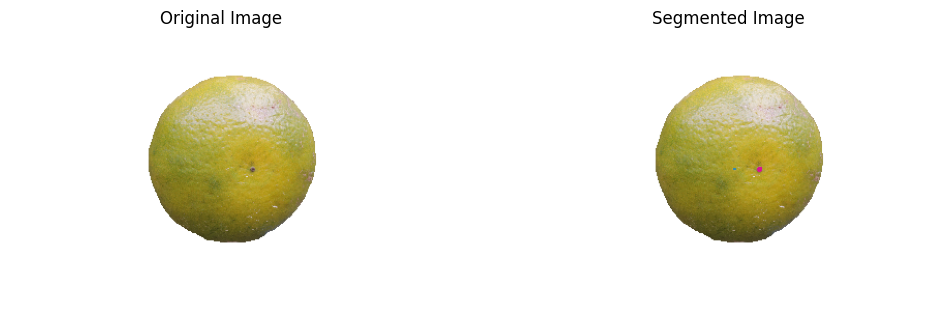

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/3_n_8_20231216.JPG


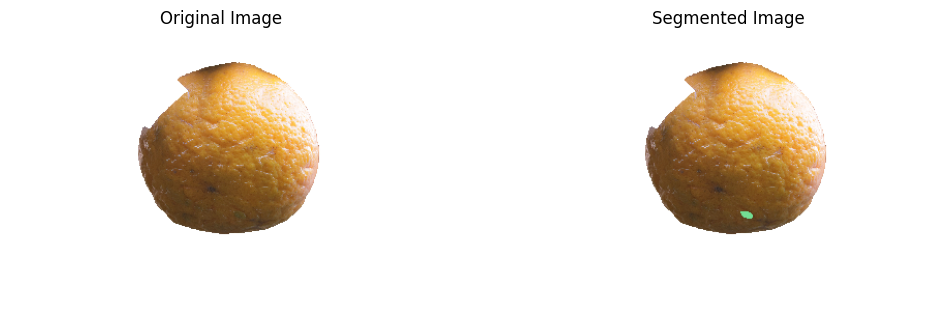

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/28_n_2_20231216.JPG


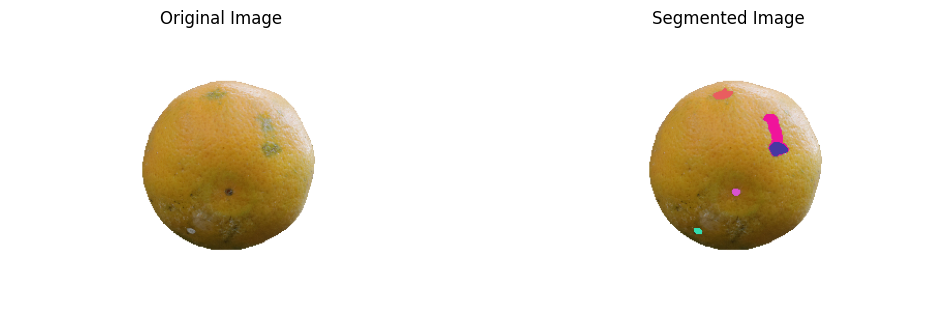

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/11_s_4_20231216.JPG


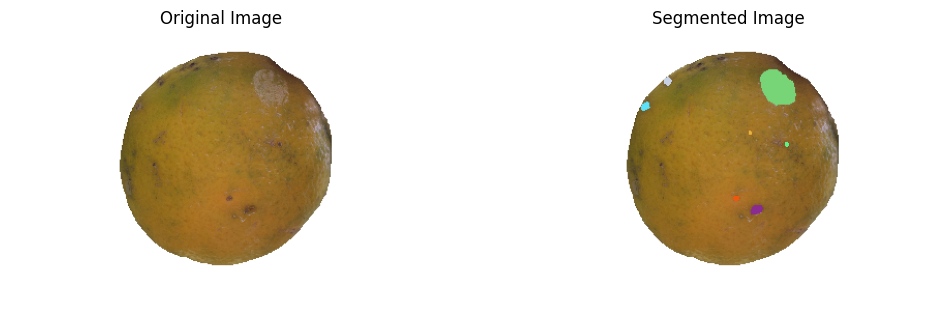

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/8_n_6_20231216.JPG


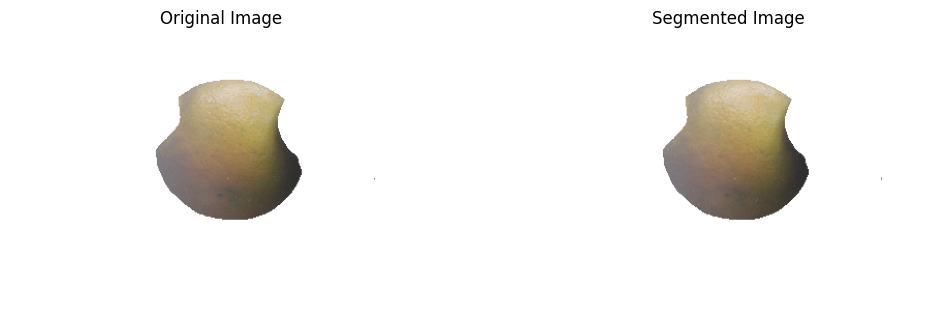

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/8_s_6_20231216.JPG


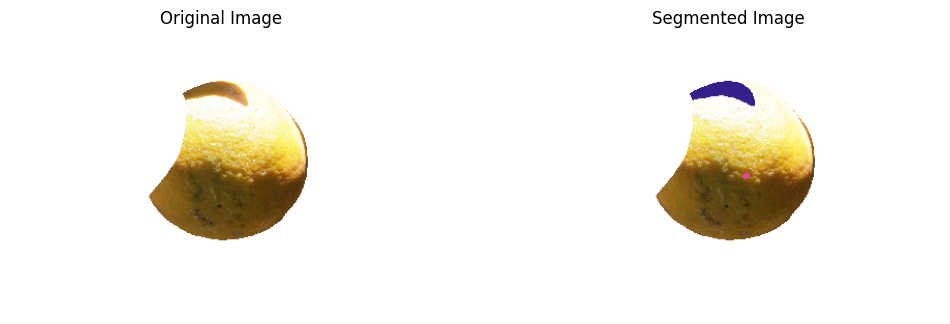

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/3_n_6_20231216.JPG


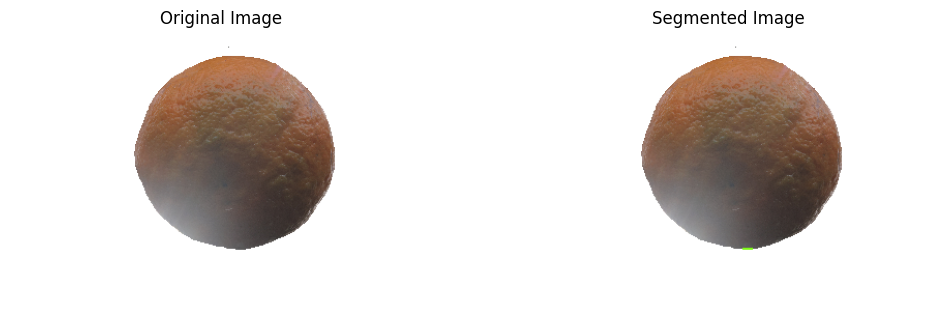

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/10_n_1_20231216.JPG


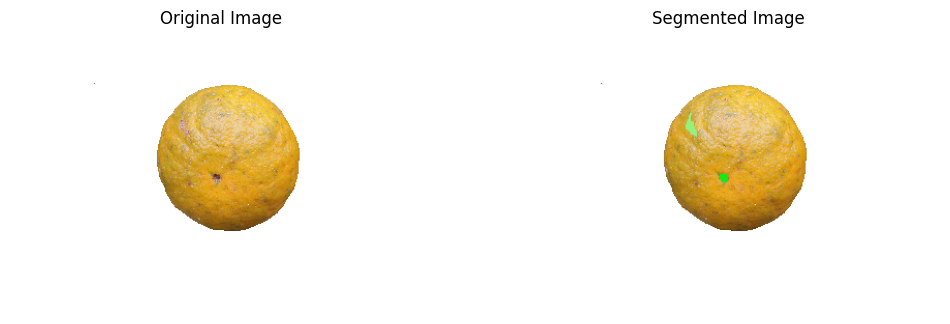

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/3_s_6_20231216.JPG


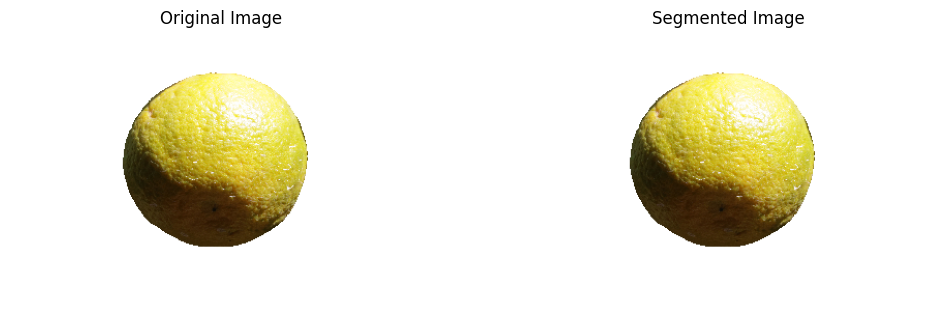

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/11_s_6_20231216.JPG


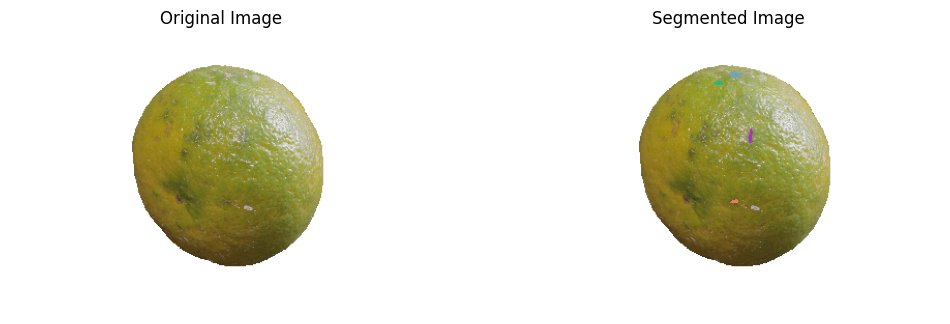

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/13_n_5_20231216.JPG


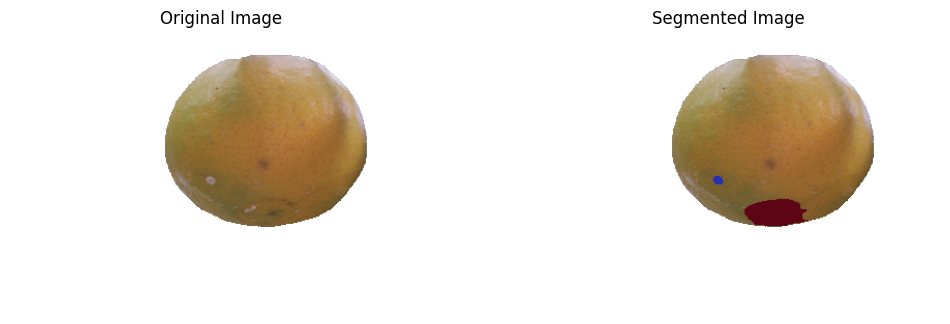

Processing: /content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/4_s_4_20231216.JPG


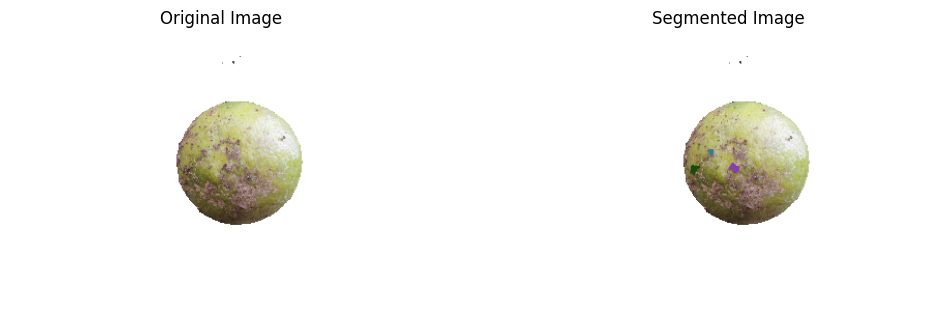

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

# Load the SAM model with mixed precision
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model with mixed precision
with torch.cuda.amp.autocast(dtype=torch.float16):
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

# Specify the folder containing the images
folder_path = '/content/drive/Othercomputers/My PC/Thesis/Segmented_by_SAM/2023/RGB/20231216/*.JPG'
image_files = glob.glob(folder_path)

# Randomly select 10 images
selected_images = random.sample(image_files, 20)

def show_filtered_masks(image, masks, max_area_threshold):
    """Display filtered masks overlaid on the original image."""
    if not masks:
        print("No inner segments found")
        return None
    overlay = image.copy()
    for mask in masks:
        # Check if the mask area is less than the max area threshold
        if mask['area'] < max_area_threshold:
            color = np.random.rand(3,)  # Random color for each mask
            segmentation = mask['segmentation']
            overlay[segmentation] = (color * 255).astype(np.uint8)
    return overlay

# Process each selected image one by one
for image_path in selected_images:
    try:
        print(f"Processing: {image_path}")

        # Load the image
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Reduce the image size significantly
        scale_factor = 0.05
        new_width = int(image.shape[1] * scale_factor)
        new_height = int(image.shape[0] * scale_factor)
        image_resized = cv2.resize(image_rgb, (new_width, new_height))

        # Calculate total image area after resizing
        total_area = new_width * new_height

        # Set the maximum segment area threshold (5% of the image area)
        max_area_threshold = 0.05 * total_area

        # Generate masks with mixed precision
        with torch.cuda.amp.autocast(dtype=torch.float16):
            masks = mask_generator.generate(image_resized)

        # Sort masks by area in descending order and remove the two largest segments
        masks_sorted = sorted(masks, key=lambda x: x['area'], reverse=True)
        filtered_masks = masks_sorted[2:] if len(masks_sorted) > 2 else []

        # Generate the segmented overlay with area filtering
        segmented_image = show_filtered_masks(image_resized, filtered_masks, max_area_threshold)

        # Display the original and segmented images side by side
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(image_resized)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Segmented Image")
        plt.imshow(segmented_image)
        plt.axis('off')
        plt.show()

        # Clear CUDA memory after processing each image
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
